# NBA Career Assisted Field Goal Tracker

### Import libraries

In [1]:
from nba_api.stats.endpoints import playbyplayv2, playergamelog, playercareerstats, boxscoreplayertrackv2
from nba_api.stats.static import players
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
plt.style.use('fivethirtyeight')

### Header for API calls

In [2]:
headers = {
    'Referer' : 'https://stats.nba.com',
    'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36',
    'x-nba-stats-origin' : 'stats',
    'x-nba-stats-token': 'true',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-origin',
    'Accept': 'application/json',
    'Connection': 'keep-alive'
}

## ENTER PLAYER NAME & SEASON TYPE:

In [3]:
player_name = 'LeBron James'

season_type = 'Playoffs'  # Regular Season, Playoffs, Pre Season, All Star

### Find PLAYER_ID by name

In [4]:
player_id = players.find_players_by_full_name(player_name)[0]['id']

print(player_name + ' Player_ID is ' + str(player_id))

LeBron James Player_ID is 2544


### Use NBA_API to get PLAYER career stats to get SEASONS played.

In [5]:
career = playercareerstats.PlayerCareerStats(player_id)
career = career.get_data_frames()[0]
seasons = career.SEASON_ID.unique()

career.head()

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,2544,2003-04,00,1610612739,CLE,19.0,79,79,3120.0,622,...,0.754,99,333,432,465,130,58,273,149,1654
1,2544,2004-05,00,1610612739,CLE,20.0,80,80,3388.0,795,...,0.750,111,477,588,577,177,52,262,146,2175
2,2544,2005-06,00,1610612739,CLE,21.0,79,79,3361.0,875,...,0.738,75,481,556,521,123,66,260,181,2478
3,2544,2006-07,00,1610612739,CLE,22.0,78,78,3190.0,772,...,0.698,83,443,526,470,125,55,250,171,2132
4,2544,2007-08,00,1610612739,CLE,23.0,75,74,3027.0,794,...,0.712,133,459,592,539,138,81,255,165,2250


### Get the GAME_IDs for all games the selected PLAYER has participaed in as a LIST.

In [6]:
games = []
games_df = pd.DataFrame()

for season in seasons:
    
    game_log = playergamelog.PlayerGameLog(player_id, season = season, headers = headers, 
                                           season_type_all_star = season_type)
    game_log = game_log.get_data_frames()[0]
    game_log['SEASON_ID'] = season
    games_df = games_df.append(game_log, ignore_index = True)
    games.append(game_log.Game_ID.values)

# Get Game_IDs in one list    
game_ids = [item for sublist in games for item in sublist]
games_df.rename(columns = {'Game_ID': 'GAME_ID'}, inplace = True)  

# Add column with team abreviation 
games_df['TEAM_ABBREVIATION'] = games_df.MATCHUP.apply(lambda x: x[0:3])

In [7]:
games_df.head()

,SEASON_ID,Player_ID,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,TEAM_ABBREVIATION
0,2005-06,2544,0040500207,"MAY 21, 2006",CLE @ DET,L,47,11,24,0.458,...,8,2,1,0,3,2,27,-16,0,CLE
1,2005-06,2544,0040500206,"MAY 19, 2006",CLE vs. DET,L,48,8,20,0.400,...,11,5,1,1,7,2,32,-2,0,CLE
2,2005-06,2544,0040500205,"MAY 17, 2006",CLE @ DET,W,47,13,30,0.433,...,5,5,2,1,2,3,32,2,0,CLE
3,2005-06,2544,0040500204,"MAY 15, 2006",CLE vs. DET,W,48,8,23,0.348,...,8,9,2,2,8,3,22,2,0,CLE
4,2005-06,2544,0040500203,"MAY 13, 2006",CLE vs. DET,W,48,9,18,0.500,...,10,10,4,1,4,2,21,9,0,CLE


### Get Play by Play for all games  on game LIST.


In [8]:
pbp_all = pd.DataFrame()
for game in game_ids:
  
    pbp = playbyplayv2.PlayByPlayV2(game, headers = headers)
    pbp = pbp.get_data_frames()[0]
    pbp_all = pbp_all.append(pbp, ignore_index=True)

### Add SEASON_ID, GAME_DATE and MATCHUP to PLAYBYPLAY DataFrame

In [9]:
# Add Seasons
pbp_all = pd.merge(pbp_all, games_df[['GAME_ID', 'GAME_DATE', 'MATCHUP','SEASON_ID' ]], on= 'GAME_ID')

### Combine HOME, VISITOR and NEUTRAL DESCRIPTIONS into a single column.

In [10]:
# Combine Descriptions and drop extra columns
pbp_all['DESCRIPTION'] = (pbp_all['VISITORDESCRIPTION'].fillna('') 
                          + pbp_all['HOMEDESCRIPTION'].fillna('') 
                          + pbp_all['NEUTRALDESCRIPTION'].fillna(''))

pbp_all.drop(['VISITORDESCRIPTION', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION'], inplace = True, axis = 1)

In [11]:
pbp_all.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,SCORE,SCOREMARGIN,PERSON1TYPE,...,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG,GAME_DATE,MATCHUP,SEASON_ID,DESCRIPTION
0,0040500207,0,12,0,1,3:38 PM,12:00,None,None,0.0,...,None,NaN,None,None,None,0,"MAY 21, 2006",CLE @ DET,2005-06,
1,0040500207,1,10,0,1,3:41 PM,12:00,None,None,4.0,...,Eric Snow,1.610613e+09,Cleveland,Cavaliers,CLE,0,"MAY 21, 2006",CLE @ DET,2005-06,Jump Ball Wallace vs. Ilgauskas: Tip to Snow
2,0040500207,2,2,1,1,3:42 PM,11:35,None,None,5.0,...,None,NaN,None,None,None,0,"MAY 21, 2006",CLE @ DET,2005-06,MISS Murray 24' 3PT Jump Shot
3,0040500207,3,4,0,1,3:42 PM,11:33,None,None,4.0,...,None,NaN,None,None,None,0,"MAY 21, 2006",CLE @ DET,2005-06,Billups REBOUND (Off:0 Def:1)
4,0040500207,4,1,1,1,3:42 PM,11:09,0 - 3,3,4.0,...,None,NaN,None,None,None,0,"MAY 21, 2006",CLE @ DET,2005-06,Prince 3PT Jump Shot (3 PTS) (Wallace 1 AST)


### Identify all ASSIST events in the PLAYBYPLAY DataFrame and keep a running count of them by player.

In the Play by Play Dataframe an assist is idetified by AST int the DESCRIPTION field. PLAYER1 is the player making the field goal and PLAYER2 is the player with the assisit.

Example:

**Boozer Driving Layup (12 PTS) (James 3 AST)**

In [12]:
ast_event = pbp_all[(pbp_all.DESCRIPTION.str.contains('AST') == True) &
                   (pbp_all.PLAYER2_ID == int(player_id))].index

assist_dic = {}
pbp_all['ASSISTED_FG'] = 0

for event in ast_event:
    player = pbp_all.PLAYER1_NAME.iloc[event]
        
    if not player in assist_dic:
        assist_dic[player] = 1
        pbp_all.loc[event, 'ASSISTED_FG'] = assist_dic[player]
    
    else:
        assist_dic[player] += 1
        pbp_all.loc[event, 'ASSISTED_FG'] = assist_dic[player]

In [13]:
pbp_all.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,SCORE,SCOREMARGIN,PERSON1TYPE,...,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG,GAME_DATE,MATCHUP,SEASON_ID,DESCRIPTION,ASSISTED_FG
0,0040500207,0,12,0,1,3:38 PM,12:00,None,None,0.0,...,NaN,None,None,None,0,"MAY 21, 2006",CLE @ DET,2005-06,,0
1,0040500207,1,10,0,1,3:41 PM,12:00,None,None,4.0,...,1.610613e+09,Cleveland,Cavaliers,CLE,0,"MAY 21, 2006",CLE @ DET,2005-06,Jump Ball Wallace vs. Ilgauskas: Tip to Snow,0
2,0040500207,2,2,1,1,3:42 PM,11:35,None,None,5.0,...,NaN,None,None,None,0,"MAY 21, 2006",CLE @ DET,2005-06,MISS Murray 24' 3PT Jump Shot,0
3,0040500207,3,4,0,1,3:42 PM,11:33,None,None,4.0,...,NaN,None,None,None,0,"MAY 21, 2006",CLE @ DET,2005-06,Billups REBOUND (Off:0 Def:1),0
4,0040500207,4,1,1,1,3:42 PM,11:09,0 - 3,3,4.0,...,NaN,None,None,None,0,"MAY 21, 2006",CLE @ DET,2005-06,Prince 3PT Jump Shot (3 PTS) (Wallace 1 AST),0


### Plot Top 10 Single-Game Assist Receipients

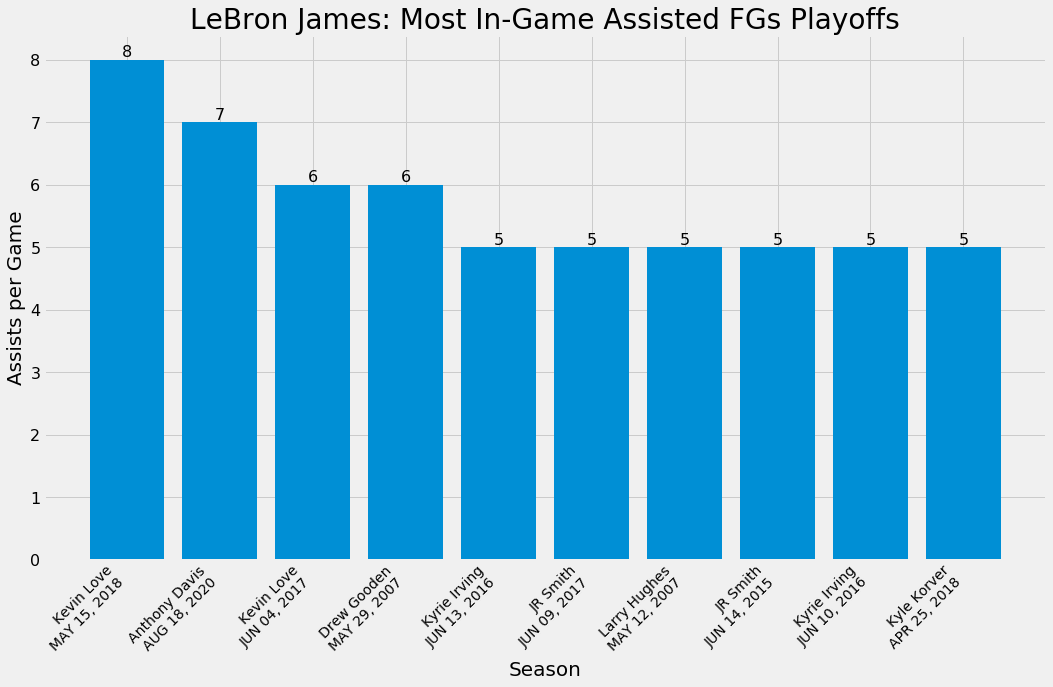

In [14]:
tot_ast_by_game_df = pbp_all.loc[ast_event].groupby(['PLAYER1_NAME', 
                                                     'GAME_ID', 'GAME_DATE'])[['ASSISTED_FG']].count().reset_index()
tot_ast_by_game_df = tot_ast_by_game_df.sort_values(by = 'ASSISTED_FG', ascending= False)

x = tot_ast_by_game_df.GAME_ID.head(10)
y = tot_ast_by_game_df.ASSISTED_FG.head(10)


fig, g = plt.subplots(figsize=(16,9))
g.bar(x , y )
plt.xlabel('Season', fontsize = 20)
plt.ylabel('Assists per Game', fontsize = 20)
plt.title(player_name + ': Most In-Game Assisted FGs ' + season_type , fontsize = 28)
plt.xticks(np.arange(10), tot_ast_by_game_df.PLAYER1_NAME.values[0:10] + '\n' + 
           tot_ast_by_game_df.GAME_DATE.values[0:10])
plt.xticks(fontsize = 14, rotation = 45, horizontalalignment='right')
plt.yticks(fontsize = 16)

for p in g.patches:
    
    height = p.get_height()
    g.text(p.get_x()+ p.get_width()/2.,
            height + 0.05,
            '{:1.0f}'.format(height),
            ha="center", fontsize = 16) 

plt.show()


### Plot total assits by teamate

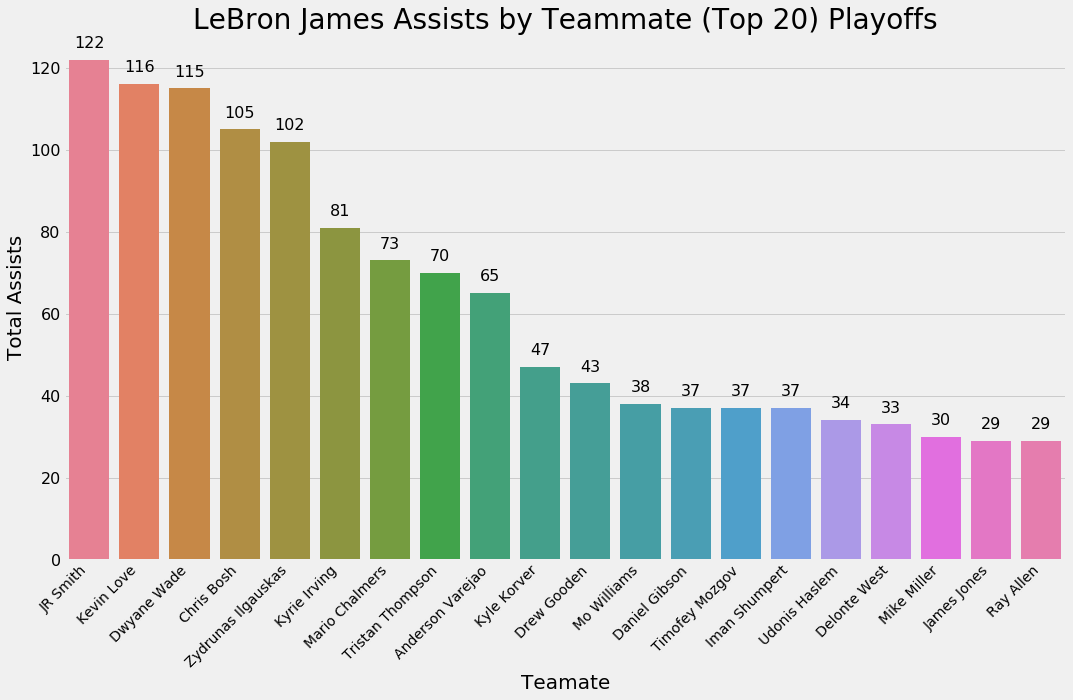

In [15]:
tot_ast_by_teammate_df = pbp_all.loc[ast_event].groupby(['PLAYER1_NAME'])[['ASSISTED_FG']].count().reset_index()
tot_ast_by_teammate_df = tot_ast_by_teammate_df.sort_values(by = 'ASSISTED_FG', ascending= False)


plt.figure(figsize=(16,9))
g = sns.barplot(x= 'PLAYER1_NAME', y ='ASSISTED_FG', 
                data = tot_ast_by_teammate_df.head(20), palette ="husl")
plt.xlabel('Teamate', fontsize = 20)
plt.ylabel('Total Assists', fontsize = 20)
plt.title(player_name + ' Assists by Teammate (Top 20) ' + season_type, fontsize = 28)
plt.xticks(fontsize = 14, rotation = 45, horizontalalignment='right')
plt.yticks(fontsize = 16)
for p in g.patches:
    
    height = p.get_height()
    g.text(p.get_x()+ p.get_width()/2.,
            height + 3,
            '{:1.0f}'.format(height),
            ha="center", fontsize = 16) 

plt.show()


## Now we need to determine how many games our selected player has played with each teammate. This will be used to determine per game stats.

To calculate assisted field-goals per game for a particular teammate we only want to consider games were both players played on. To do this we select games were both the selected player and teammate played more than 0 minutes per the game's BOXSCORE. Note that this does not guarantee that both players shared the court at any moment, only that they played on the same game.

### Get BOXSCORE DataFrame

In [16]:
boxscore_df = pd.DataFrame()

for game in game_ids:
    box_scores = boxscoreplayertrackv2.BoxScorePlayerTrackV2(game, headers = headers)
    box_scores = box_scores.get_data_frames()[0]
    boxscore_df = boxscore_df.append(box_scores, ignore_index = True)

In [17]:
boxscore_df.head(5)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,SPD,...,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,FG_PCT,DFGM,DFGA,DFG_PCT
0,0040500207,1610612739,CLE,Cleveland,2544,LeBron James,F,,46:45,0.0,...,0,0,0.0,0,0,0.0,0.458,0,0,0.0
1,0040500207,1610612739,CLE,Cleveland,2400,Drew Gooden,F,,17:30,0.0,...,0,0,0.0,0,0,0.0,0.000,0,0,0.0
2,0040500207,1610612739,CLE,Cleveland,980,Zydrunas Ilgauskas,C,,33:22,0.0,...,0,0,0.0,0,0,0.0,0.375,0,0,0.0
3,0040500207,1610612739,CLE,Cleveland,2436,Flip Murray,G,,19:07,0.0,...,0,0,0.0,0,0,0.0,0.250,0,0,0.0
4,0040500207,1610612739,CLE,Cleveland,727,Eric Snow,G,,25:09,0.0,...,0,0,0.0,0,0,0.0,0.200,0,0,0.0


### Merge with Player Game Data Frame to select only the stats from Player's team.

We have no use for opponents stats that are also pulled from the BOXSCORE query.

In [18]:
teammate_boxscore_df = pd.merge(boxscore_df, games_df[['GAME_ID', 'TEAM_ABBREVIATION', 'MATCHUP']], 
                        on= ['GAME_ID', 'TEAM_ABBREVIATION'])

In [19]:
teammate_boxscore_df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,SPD,...,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,FG_PCT,DFGM,DFGA,DFG_PCT,MATCHUP
0,0040500207,1610612739,CLE,Cleveland,2544,LeBron James,F,,46:45,0.0,...,0,0.0,0,0,0.0,0.458,0,0,0.0,CLE @ DET
1,0040500207,1610612739,CLE,Cleveland,2400,Drew Gooden,F,,17:30,0.0,...,0,0.0,0,0,0.0,0.000,0,0,0.0,CLE @ DET
2,0040500207,1610612739,CLE,Cleveland,980,Zydrunas Ilgauskas,C,,33:22,0.0,...,0,0.0,0,0,0.0,0.375,0,0,0.0,CLE @ DET
3,0040500207,1610612739,CLE,Cleveland,2436,Flip Murray,G,,19:07,0.0,...,0,0.0,0,0,0.0,0.250,0,0,0.0,CLE @ DET
4,0040500207,1610612739,CLE,Cleveland,727,Eric Snow,G,,25:09,0.0,...,0,0.0,0,0,0.0,0.200,0,0,0.0,CLE @ DET


### Get MINUTES in integer format for total minutes played

The minutes in the BOXSCORE are in the format MIN:SEC, we will changed this to total minutes played as a float. Example 20:30 -> 20.5

In [20]:
teammate_boxscore_df.MIN = teammate_boxscore_df.MIN.apply(lambda x: int(x.split(':')[0]) + 
                                                         float(x.split(':')[1])/60)

In [21]:
teammate_boxscore_df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,SPD,...,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,FG_PCT,DFGM,DFGA,DFG_PCT,MATCHUP
0,0040500207,1610612739,CLE,Cleveland,2544,LeBron James,F,,46.750000,0.0,...,0,0.0,0,0,0.0,0.458,0,0,0.0,CLE @ DET
1,0040500207,1610612739,CLE,Cleveland,2400,Drew Gooden,F,,17.500000,0.0,...,0,0.0,0,0,0.0,0.000,0,0,0.0,CLE @ DET
2,0040500207,1610612739,CLE,Cleveland,980,Zydrunas Ilgauskas,C,,33.366667,0.0,...,0,0.0,0,0,0.0,0.375,0,0,0.0,CLE @ DET
3,0040500207,1610612739,CLE,Cleveland,2436,Flip Murray,G,,19.116667,0.0,...,0,0.0,0,0,0.0,0.250,0,0,0.0,CLE @ DET
4,0040500207,1610612739,CLE,Cleveland,727,Eric Snow,G,,25.150000,0.0,...,0,0.0,0,0,0.0,0.200,0,0,0.0,CLE @ DET


### Get number of games played together with each teammate


In [22]:
play_together_event = teammate_boxscore_df[(teammate_boxscore_df.MIN > 0) & 
               (teammate_boxscore_df.PLAYER_ID != int(player_id))].index

teammate_dic = {}

for event in play_together_event:
    player = teammate_boxscore_df.PLAYER_NAME.loc[event]
        
    if not player in teammate_dic:
        teammate_dic[player] = 1
    else:
        teammate_dic[player] += 1

## Combine the Total Games and Assited FG dictionaries into one Dataframe

In [23]:
dd = defaultdict(list)

for d in (teammate_dic, assist_dic):
    for key, value in d.items():
        dd[key].append(value)

assists_df = pd.DataFrame.from_dict(dd, columns=['TOTAL_GAMES', 'FG_ASSISTED'], orient='index').fillna(0)

In [24]:
assists_df.head()

,TOTAL_GAMES,FG_ASSISTED
Drew Gooden,33,43.0
Zydrunas Ilgauskas,76,102.0
Flip Murray,13,5.0
Eric Snow,32,10.0
Donyell Marshall,32,28.0


### Add Assists/Game column

In [25]:
assists_df['AST_FG_PER_GAME']= assists_df.FG_ASSISTED/assists_df.TOTAL_GAMES

In [26]:
assists_df.sort_values(by= 'AST_FG_PER_GAME', ascending=False)

,TOTAL_GAMES,FG_ASSISTED,AST_FG_PER_GAME
Anthony Davis,3,13.0,4.333333
Antawn Jamison,11,23.0,2.090909
Kevin Love,63,116.0,1.841270
JaVale McGee,3,5.0,1.666667
Kyrie Irving,52,81.0,1.557692
...,...,...,...
Greg Oden,3,0.0,0.000000
Joe Harris,6,0.0,0.000000
Kendrick Perkins,8,0.0,0.000000
Shawn Marion,6,0.0,0.000000


### Make plots for Total Assists, Assits/Game and Max Assited FG in one figure

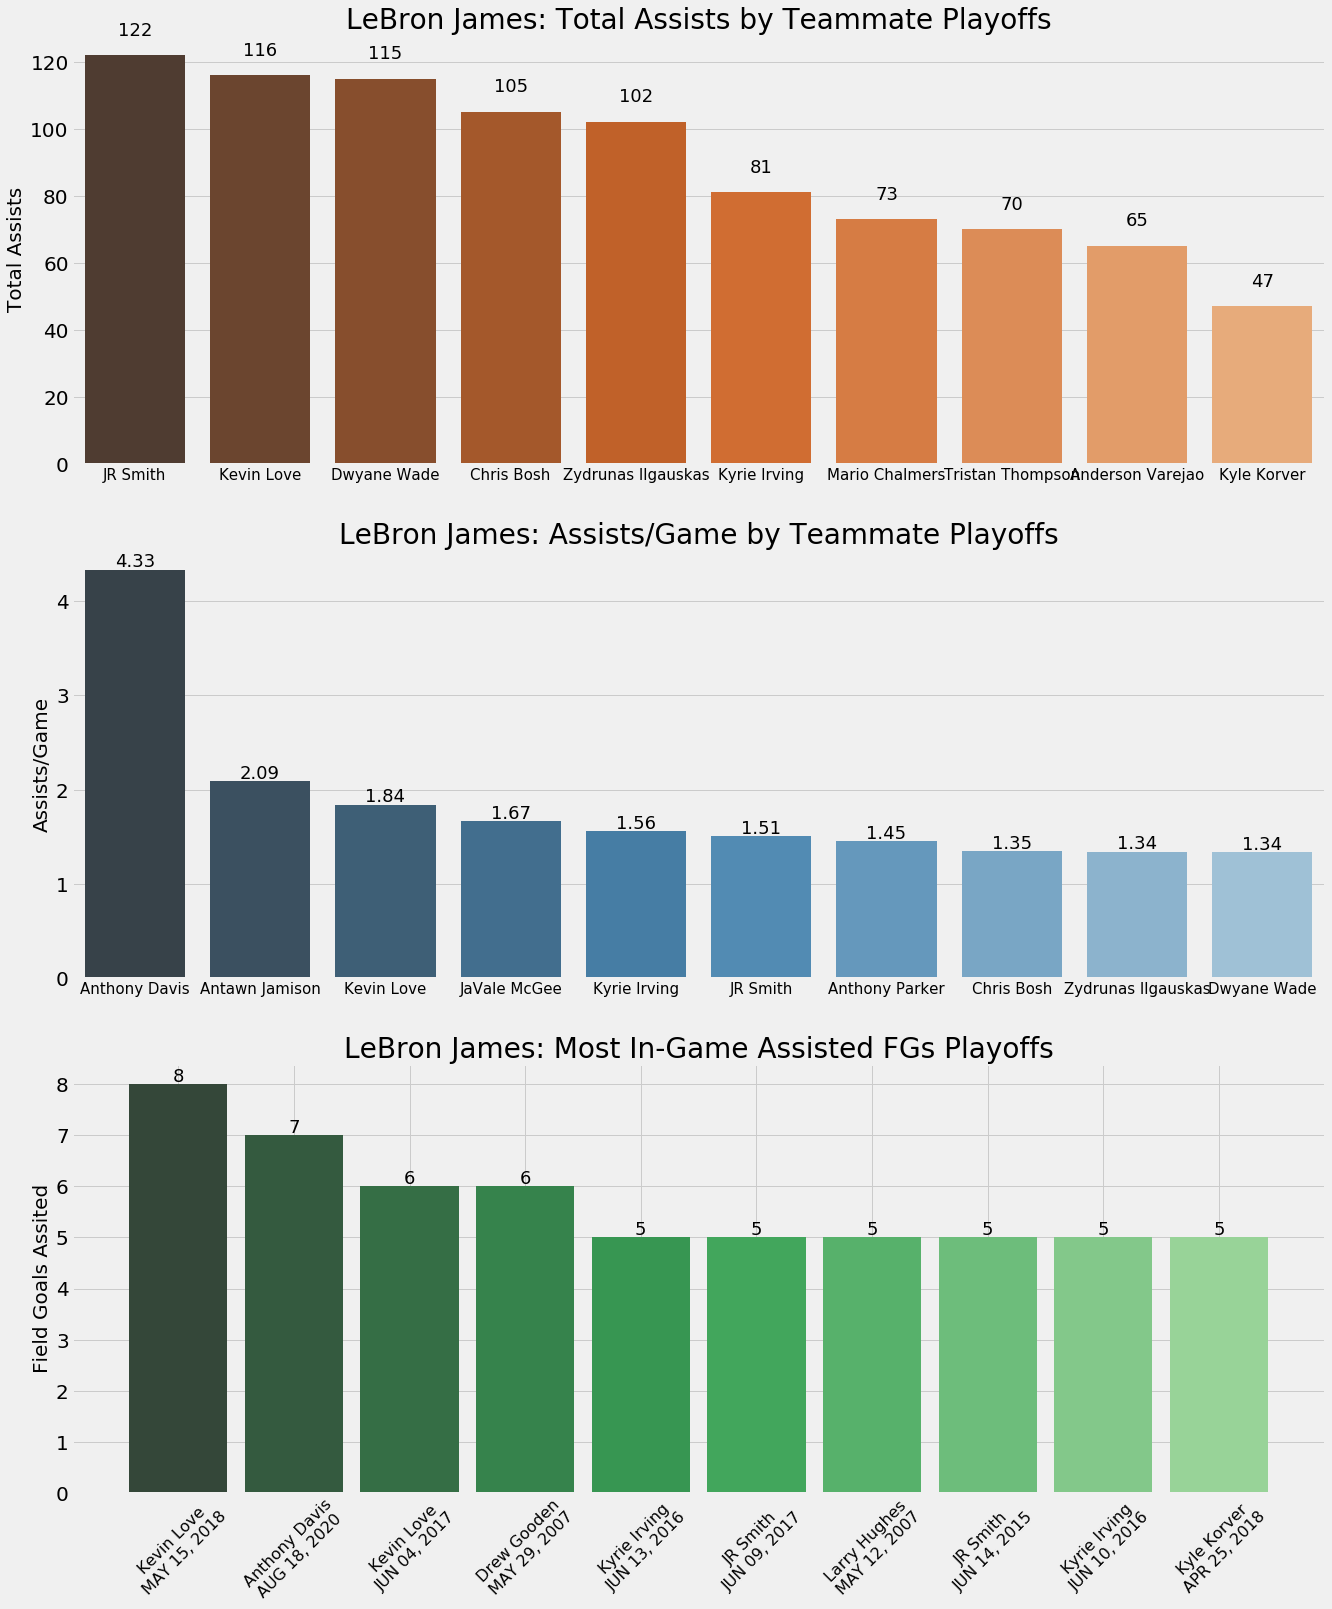

In [29]:
fig, axs = plt.subplots(nrows=3, sharex= False, sharey= False)
fig.set_size_inches(20, 25)
     
# TOTAL ASSISTS
g = (sns.barplot(x= assists_df.sort_values(by='FG_ASSISTED', ascending=False).head(10).index, 
                y ='FG_ASSISTED', data =assists_df.sort_values(by='FG_ASSISTED', ascending=False).head(10), 
                palette="Oranges_d", ax=axs[0]))

axs[0].set_ylabel('Total Assists', fontsize = 20)
axs[0].set_title(player_name + ': Total Assists by Teammate ' + season_type, fontsize = 28)
axs[0].set_xticklabels(assists_df.sort_values(by='FG_ASSISTED', ascending=False).head(10).index, fontsize = 15)
axs[0].tick_params(axis='y', which='major', labelsize=20)
for p in g.patches:
    
    height = p.get_height()
    g.text(p.get_x()+ p.get_width()/2.,
            height + 6,
            '{:1.0f}'.format(height),
            ha="center", fontsize = 18)     

# ASSISTS/GAME
g = sns.barplot(x= assists_df.sort_values(by='AST_FG_PER_GAME', ascending=False).head(10).index, 
                y ='AST_FG_PER_GAME', 
                data =assists_df.sort_values(by='AST_FG_PER_GAME', ascending=False).head(10), ax=axs[1],
               palette = 'Blues_d')
axs[1].set_title(player_name + ': Assists/Game by Teammate ' + season_type, fontsize = 28)
axs[1].set_ylabel('Assists/Game', fontsize = 20)
axs[1].set_xticklabels(assists_df.sort_values(by='AST_FG_PER_GAME', 
                                              ascending=False).head(10).index, fontsize = 15)
axs[1].tick_params(axis='y', which='major', labelsize=20)

for p in g.patches:    
    height = p.get_height()
    g.text(p.get_x()+ p.get_width()/2.,
            height + .03,
            '{:1.2f}'.format(height),
            ha="center", fontsize = 18)
    

# In Game Assisted FGs    
tot_ast_by_game_df = pbp_all.loc[ast_event].groupby(['PLAYER1_NAME', 
                                                     'GAME_ID', 'GAME_DATE'])[['ASSISTED_FG']].count().reset_index()
tot_ast_by_game_df = tot_ast_by_game_df.sort_values(by = 'ASSISTED_FG', ascending= False)

x = tot_ast_by_game_df.GAME_ID.head(10)
y = tot_ast_by_game_df.ASSISTED_FG.head(10)
   
g = axs[2].bar(x, y, color = sorted(sns.color_palette('Greens_d', n_colors = 10)),
               align = 'center',width = 0.85)

axs[2].set_ylabel('Field Goals Assited', fontsize = 20)
axs[2].set_title(player_name + ': Most In-Game Assisted FGs ' + season_type , fontsize = 28)
 
axs[2].set_xticklabels(tot_ast_by_game_df.PLAYER1_NAME.values[0:10] + '\n' + 
           tot_ast_by_game_df.GAME_DATE.values[0:10], fontsize = 16, 
                       rotation = 45, horizontalalignment='center')

axs[2].tick_params(axis='y', which='major', labelsize=20)

for p in g.patches:    
    height = p.get_height()
    axs[2].text(p.get_x()+ p.get_width()/2.,
            height + 0.05,
            '{:1.0f}'.format(height),
            ha="center", fontsize = 18) 

plt.savefig(player_name+ '_'+season_type + '.png', dpi=200)